In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pycomlink as pycml

# Rain rate dependent WAA based on Leijnse et al 2008

[Leijnse et al 2008](https://doi.org/10.1016/j.advwatres.2008.03.004) proposes a WAA parametrization based on a thin water film with rain rate dependent thickness on the antenna.

## R vs. WAA relation

Here we look at the resulting WAA for different frequencies and different rain rates 

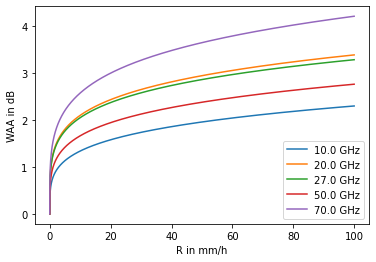

In [3]:
R = np.arange(0, 100, 0.01)

fig, ax = plt.subplots()

for f in [10, 20, 27, 50, 70]:
    waa = pycml.processing.wet_antenna.waa_leijnse_2008(f_Hz=f*1e9, R=R)
    ax.plot(R, waa, label='%2.1f GHz' % f)
ax.legend()
ax.set_xlabel('R in mm/h')
ax.set_ylabel('WAA in dB')
plt.show()

## A_obs vs. WAA relation

Since CMLs do not directly yield the rain rate `R` we want to derive the WAA from the observed attenuation `A_obs`.

This can be done by deriving the relation between `A_rain` and `waa`, where `A_rain` is calculated from `R` via the A-R relation for a given CML frequency and length. Combining `A_rain` and `waa` we get `A_obs`. In the following we will use this data to build a look-up-table (we actually use an interpolator here) to derive `waa` from any new value of `A_obs`.

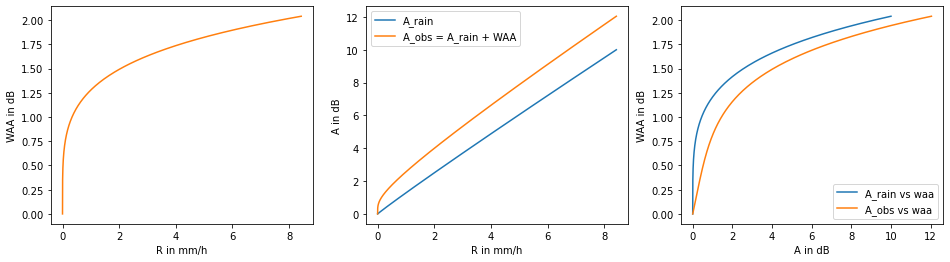

In [4]:
f_GHz = 23.0

A_rain = np.logspace(-11, 1, 1000)
A_rain[0] = 0

R = pycml.processing.k_R_relation.calc_R_from_A(A_rain, L_km=10.0, pol='V', f_GHz=f_GHz, R_min=0)
waa = pycml.processing.wet_antenna.waa_leijnse_2008(f_Hz=f_GHz*1e9, R=R)
A_obs = A_rain + waa

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
ax = axs[0]
ax.plot(R, waa, color='C1')
ax.set_xlabel('R in mm/h')
ax.set_ylabel('WAA in dB')

ax = axs[1]
ax.plot(R, A_rain, label='A_rain')
ax.plot(R, A_obs, label='A_obs = A_rain + WAA')
ax.set_xlabel('R in mm/h')
ax.set_ylabel('A in dB')
ax.legend()

ax = axs[2]
ax.plot(A_rain, waa, label='A_rain vs waa')
ax.plot(A_obs, waa, label='A_obs vs waa')
ax.set_xlabel('A in dB')
ax.set_ylabel('WAA in dB')
ax.legend();

## Relative contribution of WAA to observed attenuation

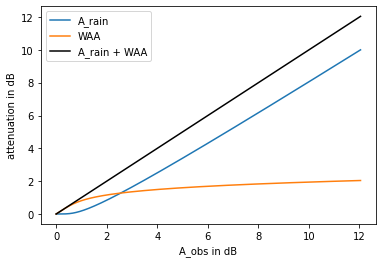

In [5]:
plt.plot(A_obs, A_rain, label='A_rain')
plt.plot(A_obs, waa, label='WAA');
plt.plot(A_obs, A_rain + waa, color='k', label='A_rain + WAA');
plt.xlabel('A_obs in dB')
plt.ylabel('attenuation in dB')
plt.legend();

## Look-up-table function to calculate WAA from A_obs

In [7]:
def waa_from_A_obs(A_obs, L, f_GHz):
    # Generate mapping from A_obs to WAA
    A_rain = np.logspace(-10, 3, 100)
    A_rain[0] = 0
    
    R = pycml.processing.k_R_relation.calc_R_from_A(A_rain, L_km=L, f_GHz=f_GHz, pol='V', R_min=0)
    waa = pycml.processing.wet_antenna.waa_leijnse_2008(f_Hz=f_GHz*1e9, R=R)
    A_obs_theoretical = A_rain + waa
    
    mapping = scipy.interpolate.interp1d(A_obs_theoretical, waa, assume_sorted=True, kind='linear')
    return mapping(A_obs)

waa_from_A_obs(np.arange(10), L=10, f_GHz=23)

array([0.        , 0.81188097, 1.15716775, 1.35323596, 1.49116094,
       1.5986414 , 1.68919034, 1.76213777, 1.82985324, 1.88777153])

The same functionality is also available directly in `pycomlink`

In [9]:
pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(np.arange(10), L_km=10, pol='V', f_Hz=23e9)

array([0.        , 0.81188097, 1.15716775, 1.35323596, 1.49116094,
       1.5986414 , 1.68919034, 1.76213777, 1.82985324, 1.88777153])

## Check if the WAA derived from the look-up-table (LUT) function fits the WAA from the equations 

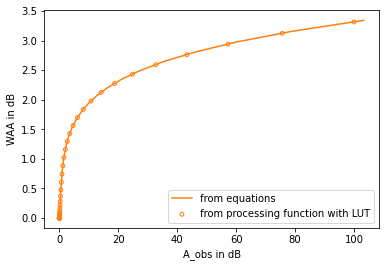

In [12]:
L_km = 10
f_Hz = 23e9

A_rain = np.logspace(-10, 2, 100)
A_rain[0] = 0

R = pycml.processing.k_R_relation.calc_R_from_A(
    A_rain,
    L_km=L_km,
    f_GHz=f_Hz / 1e9,
    pol='V',
    R_min=0,
)
waa = pycml.processing.wet_antenna.waa_leijnse_2008(
    f_Hz=f_Hz,
    R=R,
)
A_obs_theoretical = A_rain + waa

fig, ax = plt.subplots()
ax.plot(A_obs_theoretical, waa, color='C1', label='from equations')
ax.set_xlabel('A_obs in dB')
ax.set_ylabel('WAA in dB')
ax.scatter(
    A_rain,
    pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
        A_obs=A_rain,
        f_Hz=f_Hz,
        pol='V',
        L_km=L_km,
    ),
    color='C1', 
    marker='o', 
    facecolor='None', 
    s=15, 
    label='from processing function with LUT',
)
ax.legend();

# WAA estimation for real CML data

Get example CML data

In [13]:
cml_list = pycml.io.examples.get_75_cmls()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 67.47it/s]


## Estimate A_rain with the methods from above

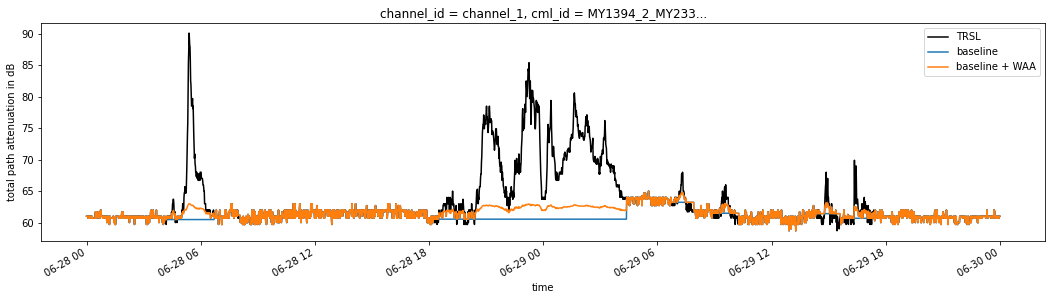

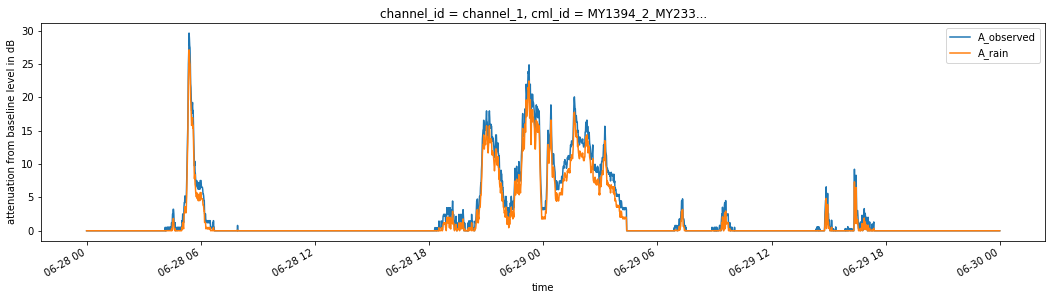

In [15]:
cml = cml_list[0]

cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
cml['trsl'] = cml.tsl - cml.rsl

cml['wet'] = cml.trsl.rolling(time=60, center=True).std(skipna=False) > 0.8

cml['wet_fraction'] = (cml.wet==1).sum() / (cml.wet==0).sum()

cml['baseline'] = pycml.processing.baseline.baseline_constant(
    trsl=cml.trsl, 
    wet=cml.wet, 
    n_average_last_dry=5,
)

cml['A'] = cml.trsl - cml.baseline
cml['A'] = cml.A.where(cml.A >= 0, 0)

cml['waa'] = pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
    A_obs=cml.A,
    f_Hz=cml.frequency * 1e9,
    pol=cml.polarization,
    L_km=cml.length,
)
    
cml['A_rain'] = cml.trsl - cml.baseline - cml.waa
cml['A_rain'] = cml.A_rain.where(cml.A_rain >= 0, 0)

cml.trsl.isel(channel_id=0).plot.line(x='time', figsize=(18, 4), label='TRSL', color='k')
cml.baseline.isel(channel_id=0).plot.line(x='time', label='baseline', color='C0')
(cml.baseline + cml.waa).isel(channel_id=0).plot.line(x='time', label='baseline + WAA', color='C1')
plt.ylabel('total path attenuation in dB')
plt.legend()

cml.A.isel(channel_id=0).plot.line(x='time', figsize=(18, 4), label='A_observed', color='C0')
cml.A_rain.isel(channel_id=0).plot.line(x='time', label='A_rain', color='C1')
plt.ylabel('attenuation from baseline level in dB')
plt.legend();

# Compare WAA from Leijnse et al 2008 and from Schleiss et al 2013

[Schleiss et al 2013](https://ieeexplore.ieee.org/document/6451115) parametrizes the WAA as a function of time, with a defined rise rate to a maximum WAA value.

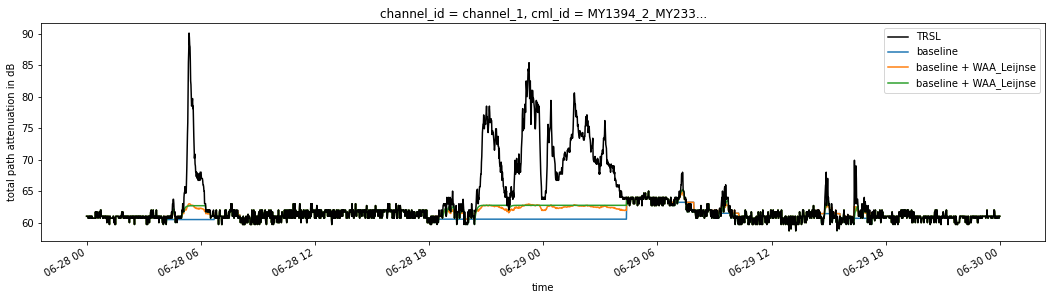

In [16]:
cml['waa_schleiss'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl, 
    baseline=cml.baseline, 
    wet=cml.wet, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

cml.trsl.isel(channel_id=0).plot.line(x='time', figsize=(18, 4), label='TRSL', color='k', zorder=10)
cml.baseline.isel(channel_id=0).plot.line(x='time', label='baseline', color='C0')
(cml.baseline + cml.waa).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_Leijnse', color='C1')
(cml.baseline + cml.waa_schleiss).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_Leijnse', color='C2')
plt.ylabel('total path attenuation in dB')
plt.legend()